<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some general parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Disambiguation" data-toc-modified-id="Disambiguation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Disambiguation</a></span><ul class="toc-item"><li><span><a href="#A-success-example" data-toc-modified-id="A-success-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A success example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Feedforward-current" data-toc-modified-id="Feedforward-current-2.1.0.1"><span class="toc-item-num">2.1.0.1&nbsp;&nbsp;</span>Feedforward current</a></span></li></ul></li></ul></li><li><span><a href="#A-failure-example" data-toc-modified-id="A-failure-example-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>A failure example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Fedforward-current" data-toc-modified-id="Fedforward-current-2.2.0.1"><span class="toc-item-num">2.2.0.1&nbsp;&nbsp;</span>Fedforward current</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#The-graph" data-toc-modified-id="The-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The graph</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Some general parameters

In [3]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

##### Create overlapped representations

In [5]:
from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

# Disambiguation

## A success example

In [114]:
%%time 
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o', 'i', 'z_pre']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [ 6]
 [17]
 [18]
 [19]]
CPU times: user 188 ms, sys: 20 ms, total: 208 ms
Wall time: 118 ms


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


In [126]:
T_cue = 2 * manager.nn.tau_s
T_recall = 2 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)
current = manager.history['i']
os1 = manager.history['o']
Z_pre = manager.history['z_pre']
z_pre_s1 = Z_pre[:, 3]

# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2

os2 = manager.history['o']
Z_pre = manager.history['z_pre']
z_pre_s2 = Z_pre[:, 13]
print(success2)
print(pattern_sequence2)
print(persistent_times2)

1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.039, 0.034, 0.04, 0.042, 0.045, 0.045, 0.06, 0.046, 0.046, 0.046, 0.046, 0.046, 0.016]
1.0
[10, 11, 12, 13, 4, 5, 6, 17, 18, 19]
[0.039, 0.034, 0.04, 0.042, 0.045, 0.045, 0.06, 0.046, 0.046, 0.151]


In [127]:
z_pre_s1.shape

(540,)

Text(0,0.5,'Unit Id')

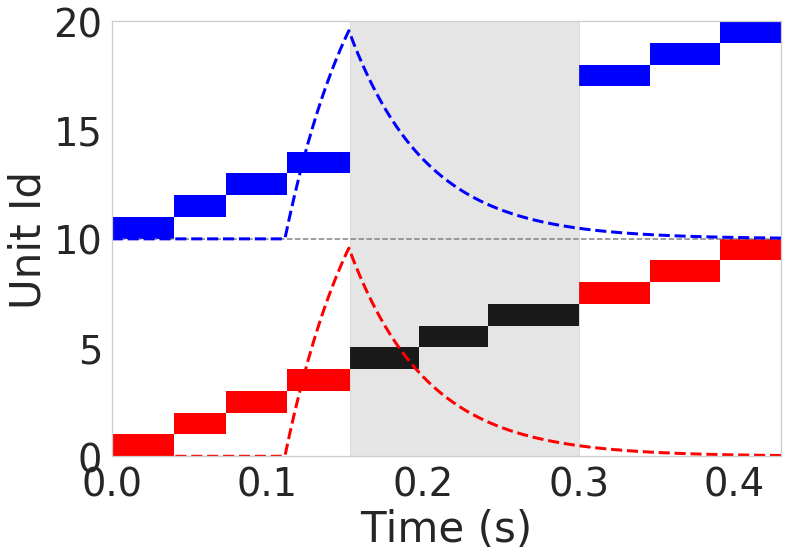

In [154]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

cmap = matplotlib.cm.binary
color1 = 'red'
color2 = 'blue'
cmap.set_under(color=color1)
cmap.set_over(color=color2)

extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax1.imshow((-1 * os1 + 2 * os2).T, origin='lower', cmap=cmap, aspect='auto', extent=extent, vmin=0.0, vmax=1.0)
ax1.axhline(0.5 * minicolumns, ls='--', color='gray')

ax1.set_xlim([0.0, 0.430])
#ax1.axvline(0.300, ls='--', color='black')
#ax1.axvline(0.153, ls='--', color='black')

ax1.plot(manager.time, 17 * z_pre_s1, '--', lw=lw - 7, color=color1)
ax1.plot(manager.time, 17 * z_pre_s2 + 10, '--', lw=lw - 7, color=color2)

ax1.fill_betweenx(y=np.linspace(0, 20, num=100), x1=0.153, x2=0.300, color='gray', alpha=0.2)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Unit Id')

#### Feedforward current

In [117]:
activity_representation

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [ 4],
       [ 5],
       [ 6],
       [17],
       [18],
       [19]])

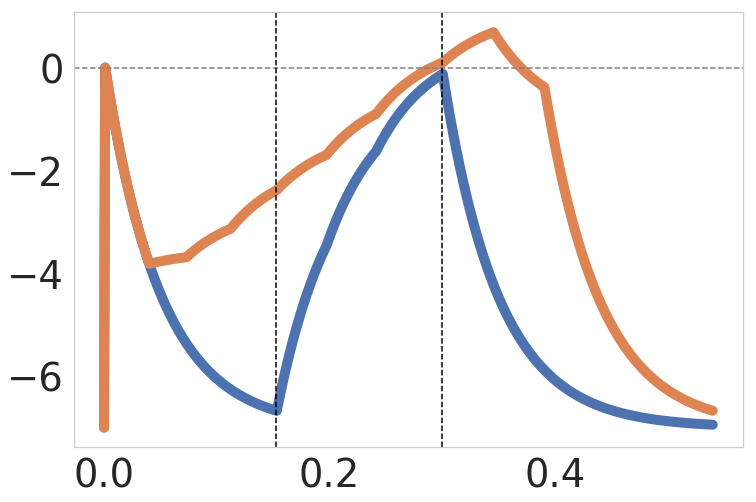

In [119]:
current = manager.history['i']
Z_pre = manager.history['z_pre']

dis_current = np.abs(current[:, 7] - current[:, 17])
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(manager.time, current[:, 7], lw=lw)
ax.plot(manager.time, current[:, 17], lw=lw)
#ax.plot(manager.time, dis_current, lw=lw)
#ax.plot(manager.time, Z_pre[:, 13])

ax.axhline(0, ls='--', color='gray')
ax.axvline(0.300, ls='--', color='black')
ax.axvline(0.153, ls='--', color='black')

## A failure example

In [149]:
%%time 
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o', 'i', 'z_pre']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.6
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [18]
 [19]]
CPU times: user 172 ms, sys: 20 ms, total: 192 ms
Wall time: 116 ms


../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


In [150]:
T_cue = 2 * manager.nn.tau_s
T_recall = 2 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

of1 = manager.history['o']
Z_pre = manager.history['z_pre']
z_pre_f1 = Z_pre[:, 1]

# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2

of2 = manager.history['o']
Z_pre = manager.history['z_pre']
z_pre_f2 = Z_pre[:, 11]

print(success2)
print(pattern_sequence2)
print(persistent_times2)

0.0
[0, 1, 2, 3, 4, 5, 6, 7, 18, 19]
[0.039, 0.029, 0.04, 0.043000000000000003, 0.045, 0.045, 0.046, 0.061, 0.046, 0.154]
1.0
[10, 11, 2, 3, 4, 5, 6, 7, 18, 19]
[0.039, 0.029, 0.04, 0.043000000000000003, 0.045, 0.045, 0.046, 0.061, 0.046, 0.154]


Text(0,0.5,'Unit Id')

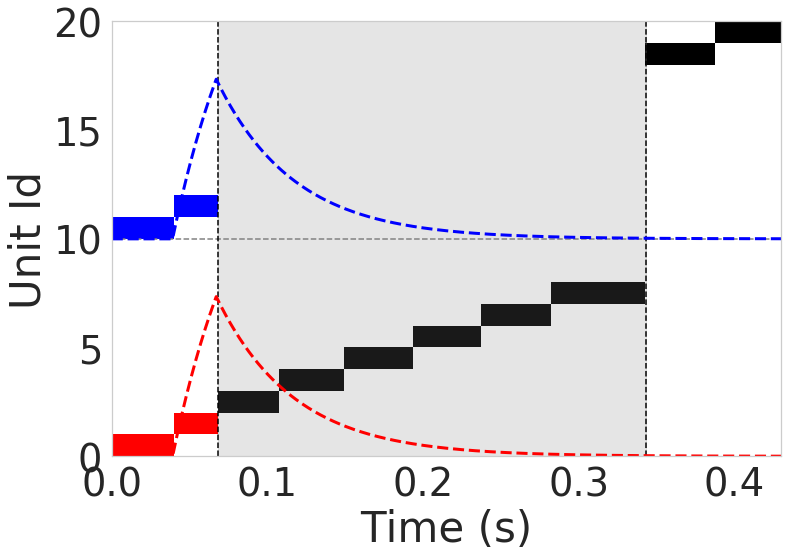

In [153]:
fig = plt.figure()
ax2 = fig.add_subplot(111)

cmap = matplotlib.cm.binary
color1 = 'red'
color2 = 'blue'
cmap.set_under(color=color1)
cmap.set_over(color=color2)

extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax2.imshow((-1 * of1 + 2 * of2).T, origin='lower', cmap=cmap, aspect='auto', extent=extent, vmin=0.0, vmax=1.0)
ax2.axhline(0.5 * minicolumns, ls='--', color='gray')
ax2.set_xlim([0.0, 0.430])
ax2.axvline(0.343, ls='--', color='black')
ax2.axvline(0.068, ls='--', color='black')

ax2.plot(manager.time, 17 * z_pre_f1, '--', lw=lw - 7, color=color1)
ax2.plot(manager.time, 17 * z_pre_f2 + 10, '--', lw=lw - 7, color=color2)

ax2.fill_betweenx(y=np.linspace(0, 20, num=100), x1=0.068, x2=0.343, color='gray', alpha=0.2)


ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Unit Id')

#### Fedforward current

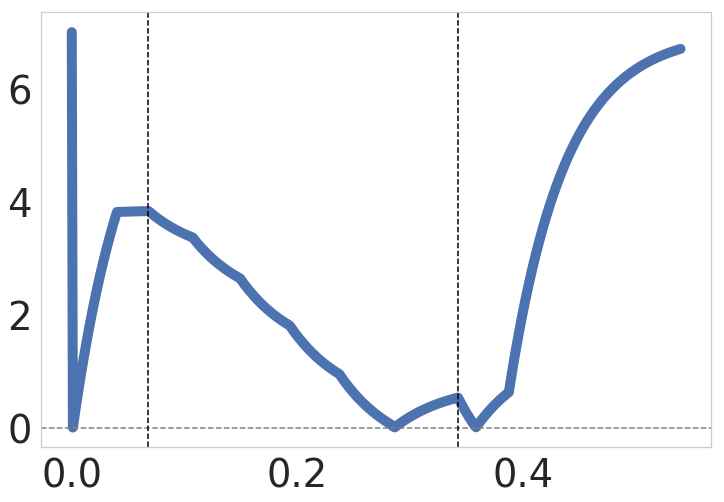

In [112]:
current = manager.history['i']
dis_current = np.abs(current[:, 7] - current[:, 17])
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(manager.time, current[:, 7], lw=lw)
#ax.plot(manager.time, current[:, 17], lw=lw)
ax.plot(manager.time, dis_current, lw=lw)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0.343, ls='--', color='black')
ax.axvline(0.068, ls='--', color='black')

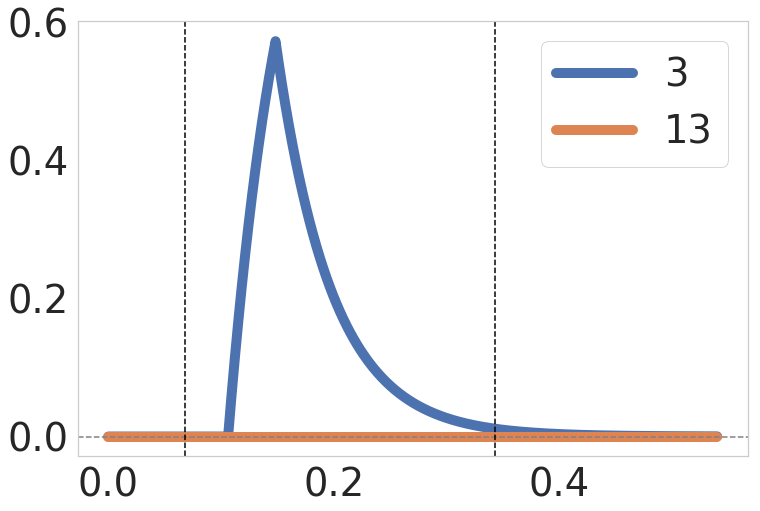

In [113]:
current = manager.history['i']
Z_pre = manager.history['z_pre']

dis_current = np.abs(current[:, 7] - current[:, 17])
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(manager.time, Z_pre[:, 3], lw=lw, label='3')
ax.plot(manager.time, Z_pre[:, 13], lw=lw, label='13')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0.343, ls='--', color='black')
ax.axvline(0.068, ls='--', color='black')

ax.legend();

# The graph

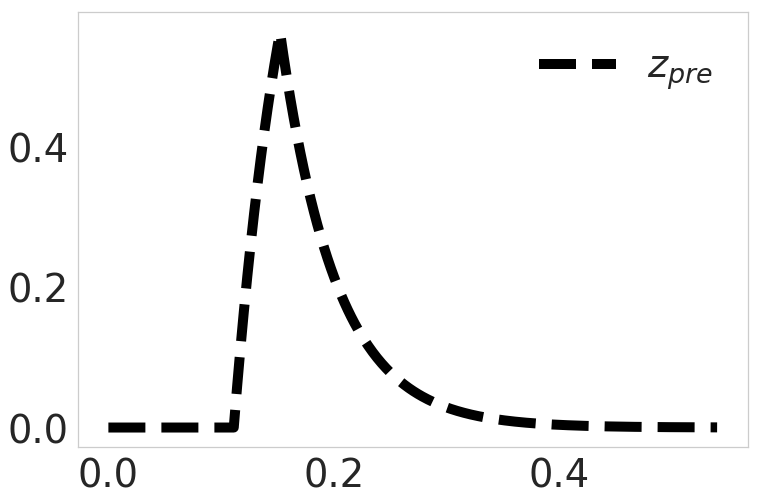

In [178]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(manager.time, z_pre_s1, '--', lw=lw , color='black', label=r'$z_{pre}$') 

ax.legend(frameon=False)

directory = '../plot_producers/'
file_name = 'disambiguation_trace' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

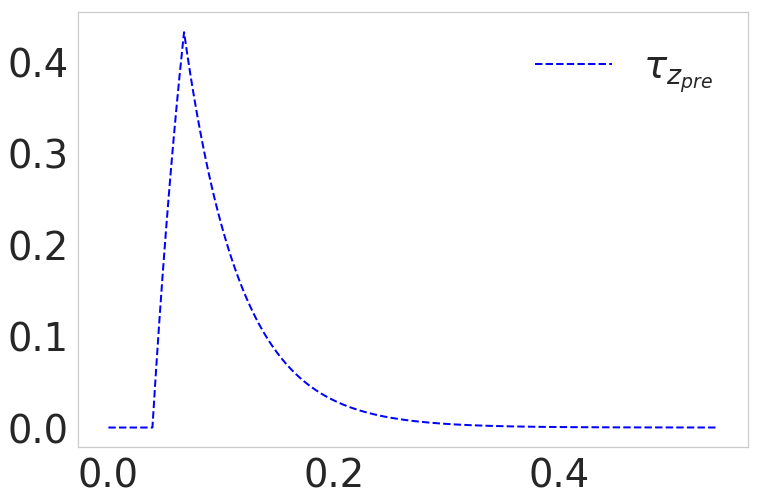

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(manager.time, z_pre_f1, '--', lw=lw - 8, color=color2, label=r'$\tau_{z_{pre}}$') 

ax.legend(frameon=False)

fig.savefig()

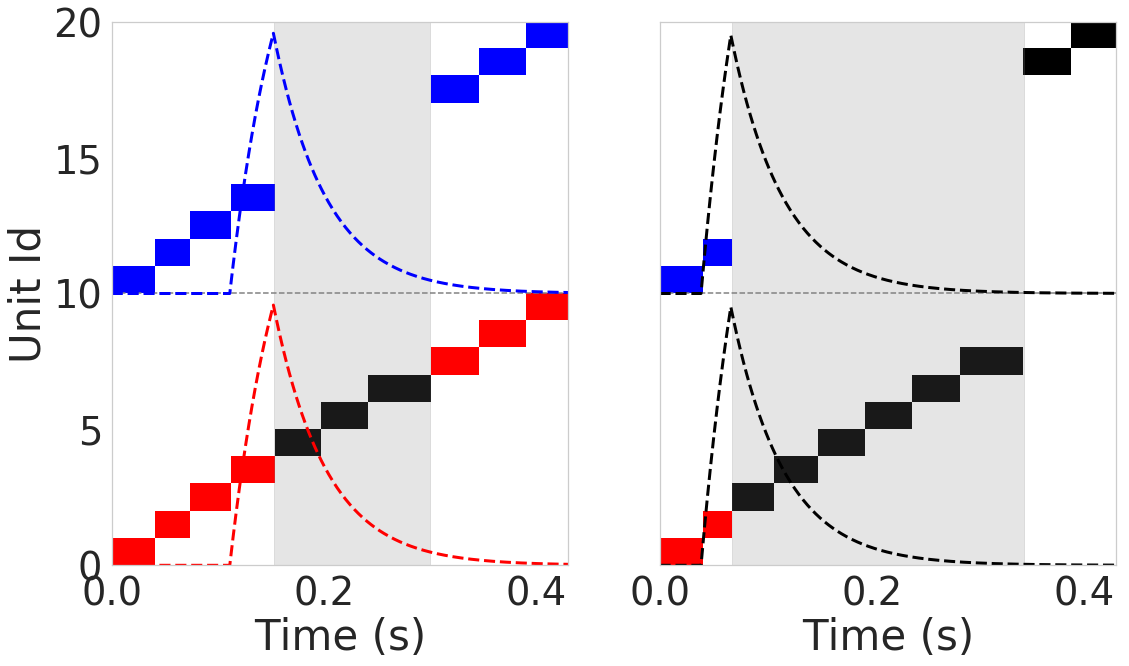

In [184]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# First figure
cmap = matplotlib.cm.binary
color1 = 'red'
color2 = 'blue'
cmap.set_under(color=color1)
cmap.set_over(color=color2)

extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax1.imshow((-1 * os1 + 2 * os2).T, origin='lower', cmap=cmap, aspect='auto', extent=extent, vmin=0.0, vmax=1.0)
ax1.axhline(0.5 * minicolumns, ls='--', color='gray')

ax1.set_xlim([0.0, 0.430])
#ax1.axvline(0.300, ls='--', color='black')
#ax1.axvline(0.153, ls='--', color='black')

ax1.plot(manager.time, 17 * z_pre_s1, '--', lw=lw - 7, color=color1)
ax1.plot(manager.time, 17 * z_pre_s2 + 10, '--', lw=lw - 7, color=color2)

ax1.fill_betweenx(y=np.linspace(0, 20, num=100), x1=0.153, x2=0.300, color='gray', alpha=0.2)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Unit Id')

# Second figure
cmap = matplotlib.cm.binary
color1 = 'red'
color2 = 'blue'
cmap.set_under(color=color1)
cmap.set_over(color=color2)

extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax2.imshow((-1 * of1 + 2 * of2).T, origin='lower', cmap=cmap, aspect='auto', extent=extent, vmin=0.0, vmax=1.0)
ax2.axhline(0.5 * minicolumns, ls='--', color='gray')
ax2.set_xlim([0.0, 0.430])
#ax2.axvline(0.343, ls='--', color='black')
#ax2.axvline(0.068, ls='--', color='black')

ax2.plot(manager.time, 22 * z_pre_f1, '--', lw=lw - 7, color='black')
ax2.plot(manager.time, 22 * z_pre_f2 + 10, '--', lw=lw - 7, color='black')

ax2.fill_betweenx(y=np.linspace(0, 20, num=100), x1=0.068, x2=0.343, color='gray', alpha=0.2)

ax2.tick_params(axis='y', which='both', labelleft=False)

ax2.set_xlabel('Time (s)')
#ax2.set_ylabel('Unit Id')

#fig.tight_layout()

#ax1.patch.set_alpha(0.0)
#ax2.patch.set_alpha(0.0)

directory = '../plot_producers/'
file_name = 'disambiguation_example' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)